# Physical Tests

## Symmetries are simple tests

One of the simplest physical test we can perform is to check that expected symmetry relationships actually hold. For instance, lets look at a square box containing fluid particles with an initial velocity alongst one of the diagonal direction (One experimental realization would be a box of fluid in free fall hitting the floor right on one of its corners). We expect that the fluid will slosh around the box, respecting a symmetry axis along that same diagonal. More to the point, we expect that (scalar) physical quantities $q(x, y)$ will map to $q(y, x)$.

The following sets up this problem:

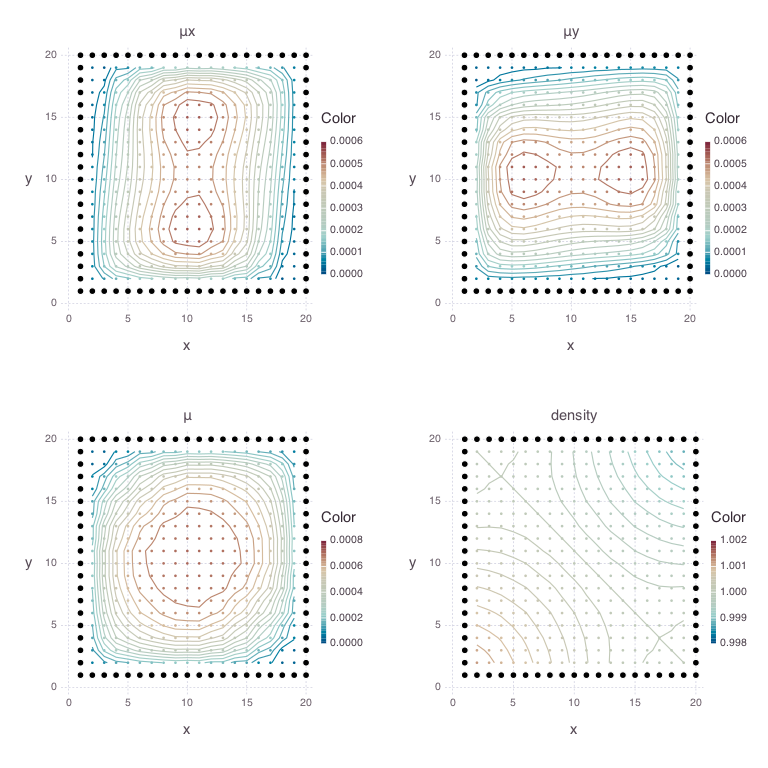

In [1]:
using LatBo
using Gadfly
# Plotting helper functions
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))

# Sets up a square box with initial velocity μ₀
Npoints, δt, δx = (20, 20), 5e-4, 1e-3
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, μ₀ = 1e-2/√3.0 * δt/δx * [1, 1])
sim.playground[:] = Playground.SOLID
sim.playground[2:(end-1), 2:(end-1)] = Playground.FLUID

# Then computes flow for a number of steps
run!(sim, nsteps=60)

# Finally, plots momenum :mu, and :density, using helper function from LatBo
set_default_plot_size(8inch, 8inch * float(Npoints[2])/float(Npoints[1]))

theme = Theme(default_point_size=1pt, highlight_width=0pt)
vstack(
  hstack(plot(:μx, sim, theme), plot(:μy, sim, theme)),
  hstack(plot(:μ, sim, theme), plot(:density, sim, theme))
)

We see above the momentum along x and y, as well as the total momentum. The symmetries are fairly clear in the pictures. But we want to actually test them numerically. This brings in issues of accuracy and how to test floating point numbers. However, symmetries are often respected up to numerical precision. Indeed, this is exactly what we are testing for. Either there is a compelling reason an algorithm breaks a symmetry - and it is a known "feature" of the algorithm from the outset - or the symmetry should emerge from the algorithm naturally.

In [5]:
using FactCheck: facts, @fact, roughly, context, not
facts("Fluid with [1, 1] velocity in closed square box: symmetry analysis") do
    context("density: ρ(x, y) ↦ ρ(y, x)") do
        ρ = density(sim)
        @fact ρ => roughly(transpose(ρ), 1e-16)
    end
    context("momentum") do
        μ = momentum(sim)
        μₓ, μy = squeeze(μ[1, :, :], 1), squeeze(μ[2, :, :], 1)       
        context("magnitude: |μ(x, y)| ↦ |μ(y, x)|") do
            magnitude = √(μₓ^2 + μy^2)
            @fact magnitude => roughly(transpose(magnitude), 1e-16)
        end
        context("vectorial: μₓ(x, y) ↦ μy(y, x)") do
            @fact μₓ => roughly(transpose(μy), 1e-16)
        end
        context("negative tests checks relationships that best not be") do
            @fact μₓ => not(roughly(μy))
            @fact μₓ => not(roughly(transpose(μₓ)))
        end
    end
end
nothing

Fluid with [1, 1] velocity in closed square box: symmetry analysis
     - density: ρ(x, y) ↦ ρ(y, x)
     - momentum
       - magnitude: |μ(x, y)| ↦ |μ(y, x)|
       - vectorial: μₓ(x, y) ↦ μy(y, x)
       - negative tests checks relationships that best not be
5 facts verified.


There are two simple ingredients to this test. First, we specifically setup the simulation wiht a input displaying a given symmetry. Then, we tested that the output recovers the same symmetry, despite that it is nowhere hard-coded into the algorithm. We were carefull to choose an example where the symmetry is respected by the alorithm; if we rotate the box by 30 degrees while keeping the orientation of the discrete LB grid constant, then the LB algorithm (and the boundary conditions) break the symmetry we are looking for. The checks would have to take into acount the degree of convergence with respect to the discrete grid, something quite a bit more challenging to setup. 

This test is not sufficient in itself: it could be that the momentum respect the symmetry of the input, but is orders of magnitude off. However, it is clear that all the right bits are interacting in mostly all the right ways.